<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

# Предварительные процедуры

## Загрузка библиотек

In [25]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import tarfile
from scipy.sparse import csr_matrix
import os
from collections import Counter, defaultdict
from node2vec import Node2Vec 
import warnings
from collections import deque
from glob import glob
import community as community_louvain
import gudhi as gd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from gudhi.representations import PersistenceImage
from matplotlib.patches import Patch
from scipy import stats
import pickle
import time
from scipy.sparse.csgraph import shortest_path
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
def load_combined(data_dir="facebook_data"):    

    print("Загрузка полного графа")
    G_combined = nx.Graph()    
    with open(os.path.join(data_dir, "facebook_combined.txt"), 'r') as f:
        for line in f:
            if line.strip():
                node1, node2 = map(int, line.strip().split())
                G_combined.add_edge(node1, node2)  
    return G_combined

In [3]:
G_combined = load_combined()

Загрузка полного графа


In [4]:
def load_all_facebook_ego_networks(data_dir="facebook_data"):
    
    facebook_dir = os.path.join(data_dir)
    edge_files = glob(os.path.join(facebook_dir, "*.edges"))    
    ego_networks = {}
    
    for edge_file in edge_files:
        ego_id = os.path.basename(edge_file).split('.')[0]      
        ego_data = load_single_ego_network(facebook_dir, ego_id)
        
        if ego_data:
            ego_networks[ego_id] = ego_data
    
    return ego_networks

def load_single_ego_network(data_dir, ego_id):
 
    base_path = os.path.join(data_dir, ego_id)
    
    ego_data = {
        'id': ego_id,
        'graph': None,
        'circles': {},
        'node_features': None,
        'ego_features': None,
        'feat_names': None,
        'node_ids': None
    }
    
    edges_file = f"{base_path}.edges"
    if os.path.exists(edges_file):
        try:
            edges = pd.read_csv(edges_file, sep=' ', header=None, names=['node1', 'node2'])
            ego_data['edges'] = edges

            G = nx.Graph()
            for _, row in edges.iterrows():
                G.add_edge(row['node1'], row['node2'])

            ego_node = int(ego_id)
            G.add_node(ego_node)
            for friend in edges['node1'].unique():
                if friend != ego_node:
                    G.add_edge(ego_node, friend)
            
            ego_data['graph'] = G
        except Exception as e:
            print(f"  Ошибка загрузки рёбер: {e}")
            return None
    
    circles_file = f"{base_path}.circles"
    if os.path.exists(circles_file):
        circles = {}
        try:
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle_name = parts[0]
                        members = list(map(int, parts[1:]))
                        circles[circle_name] = members
            ego_data['circles'] = circles
        except Exception as e:
            print(f"  Ошибка загрузки кругов: {e}")
    
    feat_file = f"{base_path}.feat"
    if os.path.exists(feat_file):
        try:
            node_features_data = np.loadtxt(feat_file)
            if len(node_features_data.shape) == 1:
                node_features_data = node_features_data.reshape(1, -1)
            
            node_ids = node_features_data[:, 0].astype(int)
            node_features = node_features_data[:, 1:]
            
            ego_data['node_features'] = node_features
            ego_data['node_ids'] = node_ids
        except Exception as e:
            print(f"  Ошибка загрузки фичей узлов: {e}")
    
    egofeat_file = f"{base_path}.egofeat"
    if os.path.exists(egofeat_file):
        try:
            ego_features = np.loadtxt(egofeat_file)
            ego_data['ego_features'] = ego_features
        except Exception as e:
            print(f"  Ошибка загрузки эго-фичей: {e}")
    
    featnames_file = f"{base_path}.featnames"
    if os.path.exists(featnames_file):
        try:
            with open(featnames_file, 'r') as f:
                feat_names = []
                for line in f:
                    line = line.strip()
                    if ' ' in line:
                        parts = line.split(' ', 1)
                        feat_names.append(parts[1])
                    else:
                        feat_names.append(line)
            ego_data['feat_names'] = feat_names
        except Exception as e:
            print(f"  Ошибка загрузки названий фичей: {e}")
    
    return ego_data

In [5]:
ego_networks = load_all_facebook_ego_networks()

# 2. Топологический анализ

### Стратегия:

* Построение комплекса Виеториса-Рипса (VR-комплекс)  
* Построение персистентных диаграмм  
* Извлечение топологических инвариантов  
* Использовать TDA фичи для анализа классификации пользовательских кругов (circles)

**Ключевое наблюдение при проведениее TDA на графе (структурный TDA):**
мера расстояние "кратчайший путь" не сработала, поскольку все узлы на расстоянии 1 или 2 от ego (получилась буквально бинарная метрика), поэтому нет топологической структуры и отсутствовали циклы H1. Вместо этого использована альтернативная метрика - рассстояние Жаккара (Jaccard), учитывающая сходство окружения (общих друзей) для узла. Расстояние между узлами *u* и *v* рассчитывалось как 


$$jaccard(u, v) = 1 - \frac{|neighbors(u) ∩ neighbors(v)|} {|neighbors(u) ∪ neighbors(v)|}$$

Такая метрика дает непрерывные значения в отрезке [0, 1]. Поскольку цель проведения TDA - обнаружение структурных сообществ, то в данном случае используется обоснование:
`Сообщество = группа с общими друзьями`

### Функции для работы

In [6]:
def build_VR (dist_matrix, max_edge_len):
    try:        
        rips = gd.RipsComplex(distance_matrix = dist_matrix, max_edge_length=max_edge_len)        
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence(min_persistence=0.001)  
        
        return rips, simplex_tree, persistence          
    except Exception as e:
        print(f"  Ошибка построения VR: {e}")


In [7]:
def compute_PD(simplex_tree):
    persistence = simplex_tree.persistence()

    persistence_by_dim = {}
    for dim in range(3):  
        persistence_by_dim[dim] = [
            (birth, death) for (d, (birth, death)) in persistence 
            if d == dim and death != float('inf')  
        ]
    
    print(f"  H0 (компоненты): {len(persistence_by_dim[0])} точек")
    print(f"  H1 (циклы): {len(persistence_by_dim[1])} точек")
    print(f"  H2 (полости): {len(persistence_by_dim[2])} точек")
    
    return persistence_by_dim

In [8]:
def visualize_PD (persistence_by_dim, title="Персистентные диаграммы"):

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    dimensions = ['H0 (компоненты)', 'H1 (циклы)', 'H2 (полости)']
    colors = ['blue', 'red', 'green']
    
    for dim, (ax, dim_name, color) in enumerate(zip(axes, dimensions, colors)):
        points = persistence_by_dim[dim]
        
        if points:
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            
            ax.scatter(births, deaths, alpha=0.6, color=color, s=30)
            
            # Диагональ (birth = death)
            max_val = max(max(births + deaths), 1.0) if births else 1.0
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)
            
            stable_points = sum(1 for b, d in points if (d - b) > max_val * 0.1)
            ax.set_title(f"{dim_name}\n{len(points)} точек, {stable_points} устойчивых")
        
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death' if dim == 0 else '')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(f'tda_diagrams/EGO-{ego_id} {title}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
def extract_topoinvariants(persistence_by_dim, distance_matrix=None, G=None):
    invariants = {}
    
    # Числа Бетти 
    for dim in [0, 1, 2]:
        points = persistence_by_dim.get(dim, [])
        invariants[f'betti_{dim}'] = len(points)
        
        if points:
            births = np.array([p[0] for p in points])
            deaths = np.array([p[1] for p in points])
            lifetimes = deaths - births
            
            # Персистентная статистика
            invariants[f'dim{dim}_total_persistence'] = float(np.sum(lifetimes))
            invariants[f'dim{dim}_mean_lifetime'] = float(np.mean(lifetimes))
            invariants[f'dim{dim}_max_lifetime'] = float(np.max(lifetimes))
            
            # Персистентная энтропия
            if len(lifetimes) > 1:
                normalized = lifetimes / np.sum(lifetimes)
                entropy = -np.sum(normalized * np.log(normalized + 1e-10))
                invariants[f'dim{dim}_entropy'] = float(entropy)
            
            # Birth/Death
            invariants[f'dim{dim}_mean_birth'] = float(np.mean(births))
            invariants[f'dim{dim}_mean_death'] = float(np.mean(deaths))
    
    # Ранги персистентности
    if persistence_by_dim.get(1):
        lifetimes_h1 = [d - b for b, d in persistence_by_dim[1]]
        thresholds = [0.01, 0.05, 0.1, 0.2]
        for t in thresholds:
            invariants[f'h1_persistent_above_{t}'] = sum(1 for lt in lifetimes_h1 if lt > t)
    
    # Инварианты графа
    if G is not None:
        invariants.update({
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'clustering': nx.average_clustering(G),
            'assortativity': nx.degree_assortativity_coefficient(G),
            'diameter': nx.diameter(G) if nx.is_connected(G) else None,
            'density': nx.density(G)
        })
    
    # Мнварианты матрицы расстояния
    if distance_matrix is not None:
        non_zero = distance_matrix[distance_matrix > 0]
        if len(non_zero) > 0:
            invariants.update({
                'mean_distance': float(np.mean(non_zero)),
                'distance_std': float(np.std(non_zero)),
                'distance_90_percentile': float(np.percentile(non_zero, 90))
            })
    
    return invariants



## TDA pipeline

In [10]:
def tda_pipeline(ego_data, ego_id=None):
    
    print("="*70)
    print(f"TDA analysis for ego-network {ego_id}")
    print("="*70)
    
    G = ego_data['graph']
    circles = ego_data.get('circles', {})
    node_features = ego_data.get('node_features', None)
    
    results = {
        'ego_id': ego_id,
        'graph_info': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'clustering': nx.average_clustering(G),
            'assortativity': nx.degree_assortativity_coefficient(G),
            'max_distance': 2  
        }
    }
    
    # Расстояние Жаккара - работает, кратчайшие пути - нет

    print("\n1. TDA на графе (структурная топология):")
    
    try:
        n_nodes = G.number_of_nodes()
        node_list = list(G.nodes())
        jaccard_matrix = np.zeros((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            neighbors_i = set(G.neighbors(node_list[i]))
            for j in range(i+1, n_nodes):
                neighbors_j = set(G.neighbors(node_list[j]))
                
                if neighbors_i or neighbors_j:
                    intersection = len(neighbors_i & neighbors_j)
                    union = len(neighbors_i | neighbors_j)
                    similarity = intersection / union if union > 0 else 0
                    distance = 1 - similarity
                else:
                    distance = 1.0
                
                jaccard_matrix[i, j] = distance
                jaccard_matrix[j, i] = distance

                
        rips, simplex_tree, persistence = build_VR(jaccard_matrix, 0.8)
        
        persistence_dict = {0: [], 1: [], 2: []}
        h1_points = []
        
        for dim, (birth, death) in persistence:
            if dim in persistence_dict and death != float('inf'):
                persistence_dict[dim].append((birth, death))
                if dim == 1:
                    h1_points.append((birth, death))
        
        counts = {dim: len(points) for dim, points in persistence_dict.items()}
                
        print(f"  H0: {counts[0]}, H1: {counts[1]}, H2: {counts[2]}")
        
        if h1_points:
            lifetimes = [d - b for b, d in h1_points]
            
            print(f"  Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")
            
            persistence_by_dim = {}
            for dim in [0, 1, 2]:
                persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence 
                                           if d == dim and death != float('inf')]
            
            visualize_PD(persistence_by_dim, title=f"Graph Persistance Diagramm")
   
        
        results['graph_tda'] = {
            'metric': 'jaccard',
            'distance_matrix': jaccard_matrix,
            'persistence': persistence_dict,
            'counts': counts,
            'h1_points': h1_points,
            'h1_count': len(h1_points)
        }
        
    except Exception as e:
        print(f"  Ошибка: {e}")
    

    if node_features is not None:
        print("\n2. TDA на эмбеддингах (семантическая топология):")      
        try:
            # Подготовка эмбеддингов
            feat_node_ids = ego_data.get('node_ids', [])
            if len(feat_node_ids) > 0:
                node_to_feat_idx = {node_id: i for i, node_id in enumerate(feat_node_ids)}
                graph_nodes = sorted(list(G.nodes()))
                
                embeddings_list = []
                for node in graph_nodes:
                    if node in node_to_feat_idx:
                        embeddings_list.append(node_features[node_to_feat_idx[node]])
                    else:
                        embeddings_list.append(np.zeros(node_features.shape[1]))
                
                embeddings = np.array(embeddings_list)

                distance_matrix = euclidean_distances(embeddings)
                non_zero_dists = distance_matrix[distance_matrix > 0]
                
                if len(non_zero_dists) > 0:
                    max_edge_length = np.percentile(non_zero_dists, 85)
                else:
                    max_edge_length = 5.0


                rips_emb, simplex_tree_emb, persistence_emb = build_VR(distance_matrix,max_edge_length)

                persistence_dict_emb = {0: [], 1: [], 2: []}
                h1_points_emb = []
                
                for dim, (birth, death) in persistence_emb:
                    if dim in persistence_dict_emb and death != float('inf'):
                        persistence_dict_emb[dim].append((birth, death))
                        if dim == 1:
                            h1_points_emb.append((birth, death))
                
                counts_emb = {dim: len(points) for dim, points in persistence_dict_emb.items()}
                
                print(f"  H0: {counts_emb[0]}, H1: {counts_emb[1]}, H2: {counts_emb[2]}")
                
                if h1_points_emb:
                    lifetimes = [d - b for b, d in h1_points_emb]
                    print(f"  Среднее время жизни циклов: {np.mean(lifetimes):.4f}")
                    print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")

                for dim in [0, 1, 2]:
                    persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence_emb 
                                               if d == dim and death != float('inf')]
                visualize_PD(persistence_by_dim, title=f"Embedding Persistance Diagramm")
                
                results['embedding_tda'] = {
                    'distance_matrix': distance_matrix,
                    'persistence': persistence_dict_emb,  
                    'h1_points': h1_points_emb,
                    'embeddings': embeddings
                }
        
        except Exception as e:
            print(f"  Ошибка: {e}")
    

    print("\n3. Извлечение топо-фичей:")
    
    try:
        if 'graph_tda' in results:
            jaccard_matrix = results['graph_tda']['distance_matrix']
            n_nodes = jaccard_matrix.shape[0]
            
            node_features_topo = []
            
            for i in range(n_nodes):
                features = []               

                jaccard_dists = jaccard_matrix[i]
                
                features.append(np.mean(jaccard_dists[jaccard_dists > 0]))
                features.append(np.min(jaccard_dists[jaccard_dists > 0]))                
                features.append(np.std(jaccard_dists[jaccard_dists > 0]))
                
                close_neighbors = np.sum(jaccard_dists < 0.5)
                features.append(close_neighbors)
                
                node_features_topo.append(features)
            
            topo_features = np.array(node_features_topo)
            
            results['topological_features'] = {
                'jaccard_based': topo_features,
                'node_ids': sorted(list(G.nodes())),
                'feature_names': [
                    'mean_jaccard_distance',
                    'min_jaccard_distance', 
                    'std_jaccard_distance',
                    'close_neighbors_count'
                ]
            }
            
            print(f"  Извлечено признаков: {topo_features.shape}")
            print(f"  Пример признаков узла 0: {topo_features[0]}")
    
    except Exception as e:
        print(f"  Ошибка: {e}")
        results['topological_features'] = {}
    


    print("\n4. Извлечение топологических инвариантов:")
    
    # Инварианты графа
    if 'graph_tda' in results and 'persistence' in results['graph_tda']:
       
        persistence_by_dim = results['graph_tda']['persistence']         
        
        graph_invariants = extract_topoinvariants(persistence_by_dim, results['graph_tda'].get('distance_matrix'), G)              
        results['graph_tda']['invariants'] = graph_invariants
        
        print(f"\n  Инварианты графа:")
        for key, value in graph_invariants.items():
            print(f"    {key}: {value}")

       
    # Инварианты эмбеддингов
    if 'embedding_tda' in results and 'persistence' in results['embedding_tda']:
        persistence_by_dim_emb = results['embedding_tda']['persistence']          
        emb_invariants = extract_topoinvariants(persistence_by_dim_emb, results['embedding_tda'].get('distance_matrix'))
        
        results['embedding_tda']['invariants'] = emb_invariants        
        print(f"\n  Инварианты эмбеддингов:")

        for key, value in emb_invariants.items():
            print(f"    {key}: {value}")       
    
    if circles and 'topological_features' in results:
        print("\n5. Сравнение с пользовательскими кругами:")
        
        # Гипотеза 1: Круги ≈ структурные сообщества в графе
        
        print("\n  5.1. Структурная топология vs круги:")
        
        try:
            structural_features = results['topological_features']['jaccard_based']
            node_ids = results['topological_features']['node_ids']
            
            labels = np.zeros(len(node_ids))
            node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
            
            for circle_idx, (circle_name, members) in enumerate(circles.items()):
                for member in members:
                    if member in node_to_idx:
                        labels[node_to_idx[member]] = circle_idx + 1

            mask = labels > 0
            if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                silhouette_structural = silhouette_score(structural_features[mask], labels[mask].astype(int))                            
                print(f"    Силуэтный коэффициент (структурный): {silhouette_structural:.3f}")
                
                if silhouette_structural > 0.3:
                    print(f"    Круги соответствуют структурным сообществам")
                elif silhouette_structural > 0:
                    print(f"    Слабая структурная корреляция")
                else:
                    print(f"    Круги НЕ соответствуют структурным сообществам")
        
        except Exception as e:
            print(f"    Ошибка структурного сравнения: {e}")
        

        # Гипотеза 2: Круги ≈ семантические кластеры в пространстве признаков

        if 'embedding_tda' in results and 'embeddings' in results['embedding_tda']:
            print("\n  5.2. Семантическая топология vs круги:")
            
            try:
                embeddings = results['embedding_tda']['embeddings']  # (334, 224)
                
                if 'node_ids' in results['topological_features']:
                    node_ids = results['topological_features']['node_ids']
                    labels = np.zeros(len(node_ids))
                    node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                    
                    for circle_idx, (circle_name, members) in enumerate(circles.items()):
                        for member in members:
                            if member in node_to_idx:
                                labels[node_to_idx[member]] = circle_idx + 1
                    
                    mask = labels > 0
                    if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                        silhouette_semantic = silhouette_score(embeddings[mask], labels[mask].astype(int))                                          
                        print(f"    Силуэтный коэффициент (семантический): {silhouette_semantic:.3f}")

                        if silhouette_semantic > 0.3:
                            print(f"    Круги соответствуют семантическим кластерам")
                        elif silhouette_semantic > 0:
                            print(f"    Слабая семантическая корреляция")
                        else:
                            print(f"    Круги НЕ соответствуют семантическим кластерам")
                
                            
            except Exception as e:
                print(f"    Ошибка семантического сравнения: {e}")
        

        print("\n  5.3. Визуализация сравнений:")
        
        try:
            if 'topological_features' in results and 'embedding_tda' in results:
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))

                structural_features = results['topological_features']['jaccard_based']
                embeddings = results['embedding_tda']['embeddings']
                node_ids = results['topological_features']['node_ids']

                labels = np.zeros(len(node_ids))
                node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                
                for circle_idx, (circle_name, members) in enumerate(circles.items()):
                    for member in members:
                        if member in node_to_idx:
                            labels[node_to_idx[member]] = circle_idx + 1
                
                ax = axes[0, 0]
                if structural_features.shape[1] >= 2:
                    scatter = ax.scatter(
                        structural_features[:, 0], 
                        structural_features[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('Mean Jaccard distance')
                    ax.set_ylabel('Min Jaccard distance')
                    ax.set_title('Structural features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')

                ax = axes[0, 1]
                if embeddings.shape[1] >= 2:
                    
                    # PCA для визуализации                    
                    if embeddings.shape[1] > 2:
                        pca = PCA(n_components=2)
                        embeddings_2d = pca.fit_transform(embeddings)
                    else:
                        embeddings_2d = embeddings
                    
                    scatter = ax.scatter(
                        embeddings_2d[:, 0], 
                        embeddings_2d[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('PC1')
                    ax.set_ylabel('PC2')
                    ax.set_title('Semantic features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')
                

                ax = axes[1, 0]
                comparison_data = []

                if 'silhouette_structural' in locals():
                    comparison_data.append(('Структурный', silhouette_structural))
                
                if 'silhouette_semantic' in locals():
                    comparison_data.append(('Семантический', silhouette_semantic))
                
                if comparison_data:
                    names, values = zip(*comparison_data)
                    colors = ['skyblue' if v > 0 else 'lightcoral' for v in values]
                    bars = ax.bar(names, values, color=colors, alpha=0.7)
                    
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
                    ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, 
                              label='Хорошая кластеризация (0.3)')
                    ax.set_ylabel('Silhouette')
                    ax.set_title('Сравнение качества кластеризации кругов')
                    ax.legend()
                    
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom')
                        
                ax = axes[1, 1]
                circle_stats = []
                circle_names = []
                
                for circle_name, members in circles.items():
                    member_indices = [node_to_idx[m] for m in members if m in node_to_idx]
                    if member_indices:

                        if structural_features.shape[1] > 0:
                            circle_features = structural_features[member_indices]
                            avg_similarity = 1 - np.mean(circle_features[:, 0])  
                            circle_stats.append(avg_similarity)
                            circle_names.append(circle_name[:10]) 
            
                if circle_stats:
                    bars = ax.bar(range(len(circle_stats)), circle_stats, alpha=0.7)
                    ax.set_xlabel('Circles')
                    ax.set_ylabel('Средняя структурная схожесть')
                    ax.set_title('Структурная сплоченность кругов')
                    ax.set_xticks(range(len(circle_names)))
                    ax.set_xticklabels(circle_names, rotation=45, ha='right', fontsize=8)
                
                plt.tight_layout()
                plt.savefig(f'tda_diagrams/EGO-{ego_id} Circles Comparison.png', dpi=150, bbox_inches='tight')
                plt.show()
        
        except Exception as e:
            print(f"    Ошибка визуализации: {e}")
        
    return results

### Запуск

TDA analysis for ego-network 1684

1. TDA на графе (структурная топология):
  H0: 738, H1: 218, H2: 0
  Среднее время жизни: 0.0224
  Максимальное время жизни: 0.0972


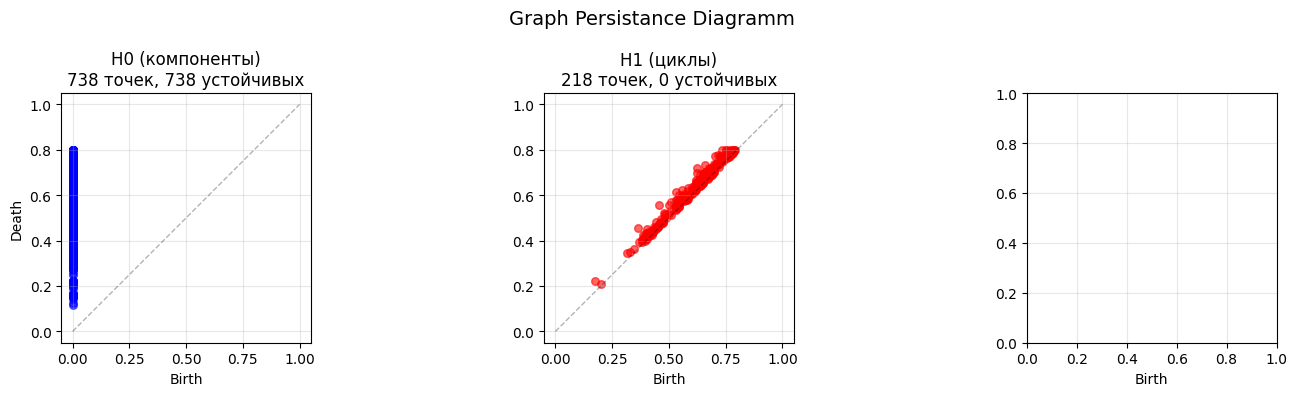


2. TDA на эмбеддингах (семантическая топология):
  H0: 619, H1: 73, H2: 0
  Среднее время жизни циклов: 0.2687
  Максимальное время жизни: 0.5040


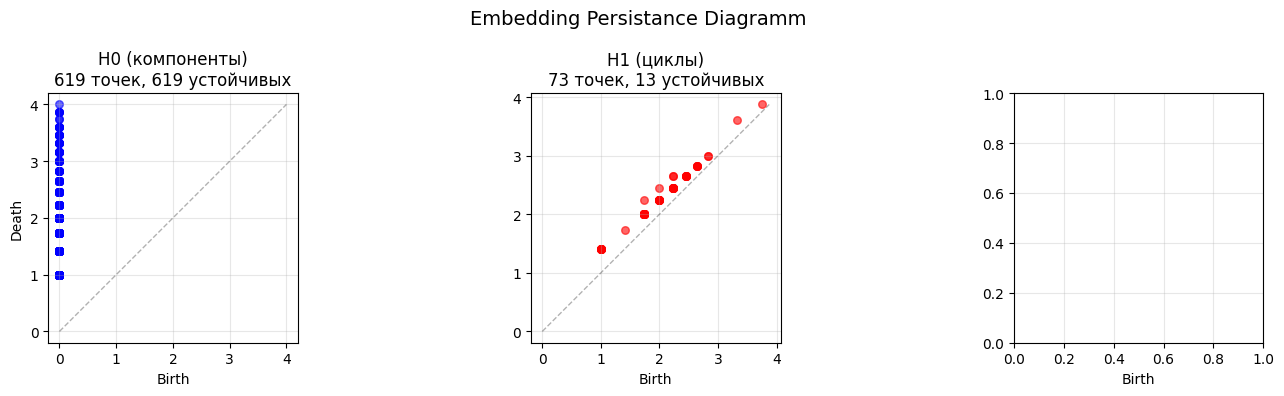


3. Извлечение топо-фичей:
  Извлечено признаков: (787, 4)
  Пример признаков узла 0: [ 0.92510551  0.32978723  0.13538507 27.        ]

4. Извлечение топологических инвариантов:

  Инварианты графа:
    betti_0: 738
    dim0_total_persistence: 398.1413211682657
    dim0_mean_lifetime: 0.5394868850518505
    dim0_max_lifetime: 0.8
    dim0_entropy: 6.560658659087592
    dim0_mean_birth: 0.0
    dim0_mean_death: 0.5394868850518505
    betti_1: 218
    dim1_total_persistence: 4.879091896320487
    dim1_mean_lifetime: 0.022381155487708655
    dim1_max_lifetime: 0.09722222222222221
    dim1_entropy: 5.081871857521634
    dim1_mean_birth: 0.5941367377215534
    dim1_mean_death: 0.6165178932092621
    betti_2: 0
    h1_persistent_above_0.01: 154
    h1_persistent_above_0.05: 16
    h1_persistent_above_0.1: 0
    h1_persistent_above_0.2: 0
    num_nodes: 787
    num_edges: 14810
    clustering: 0.540621197635205
    assortativity: -0.06579494461431706
    diameter: 2
    density: 0.0478837082

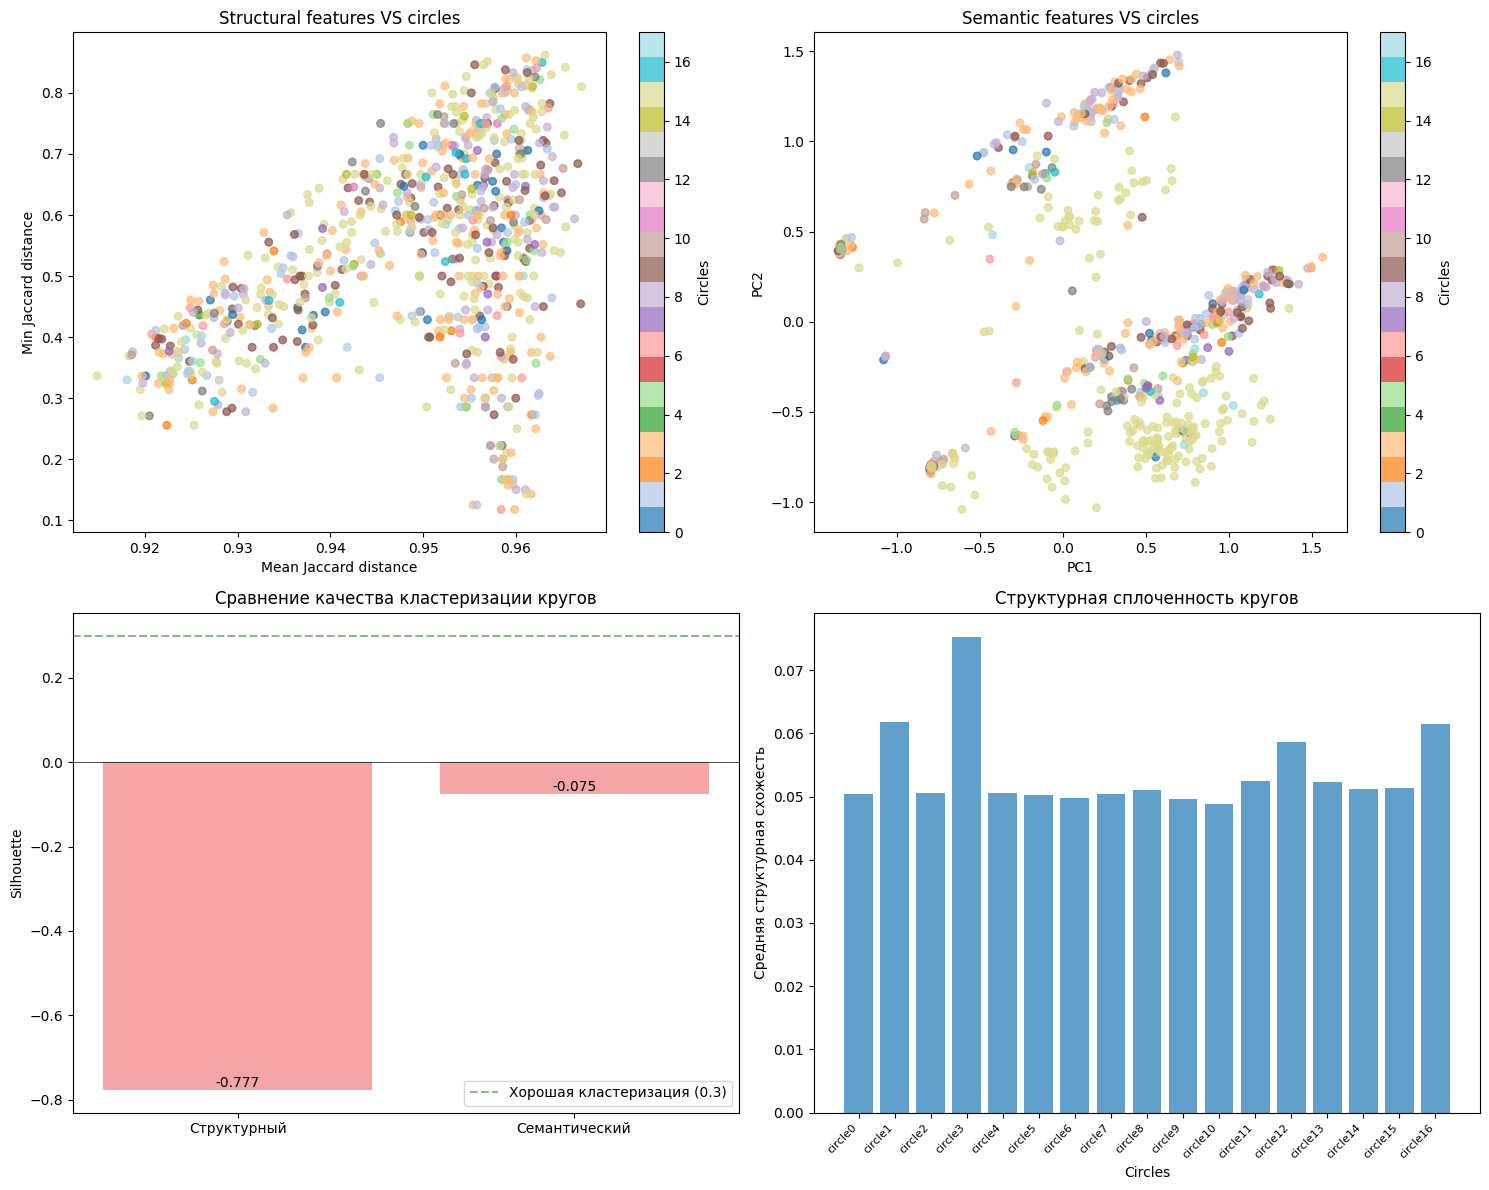


Summary for ego 1684:
  Узлов: 787
  Рёбер: 14810
  Коэффициент кластеризации: 0.541
  Найдено циклов H1: 218
  Извлечено топологических фичей: (787, 4)

TDA анализ завершен успешно!


In [12]:
ego_id='1684'
results_tda = tda_pipeline(ego_networks[ego_id], ego_id)

if results_tda:
    # Сводка результатов
    print(f"\nSummary for ego {ego_id}:")
    print(f"  Узлов: {results_tda['graph_info']['num_nodes']}")
    print(f"  Рёбер: {results_tda['graph_info']['num_edges']}")
    print(f"  Коэффициент кластеризации: {results_tda['graph_info']['clustering']:.3f}")
    
    if 'graph_tda' in results_tda:
        print(f"  Найдено циклов H1: {results_tda['graph_tda']['h1_count']}")
    
    if 'topological_features' in results_tda:
        shape = results_tda['topological_features']['jaccard_based'].shape
        print(f"  Извлечено топологических фичей: {shape}")
    
    print(f"\nTDA анализ завершен успешно!")
    
else:
    print(f"\nTDA успешно провален!")

## Результаты TDA для ego-network:
Я не стал визуализировать результаты для всех 10 ego-network, а оставил только 1, но выводы будут по всем 10 полученным результатам.
1. Вместо исходной гипотезы "пользовательские круги соответствуют геометрическим\семантическим кластерам" получилось ровно наоборот - ни в одной из ego-network круги не соответствуют ни семантическим, ни структурным кластерам. Результат основан на силуэтном коэффициенте, который не превысил -0.02 (это был самый максимальный результат) - т.е. узлы внутри одного круга в среднем больше похожи на узлы из других, чем на свои
2. Пользователи размечают круги по разным критериям, участники которых, зачастую, вообще не похожи между собой (например "коллеги", "соседи", "школьные знакомые" и пр). Их объединяет география, время, эмоции, интересы, а не наличие связей с остальными участниками ego-network, что выражено в низком времени жизни структурных циклов H1
3. Время жизни семантических циклов H1 всегда больше структурных, что подтверждает гипотезу об объединении пользовательских кругов по принципу эмоций или интересов - такие циклы являются более значимыми топологическими фичами
4. Поскольку количество семантических циклов всегда меньше структурых, это говорит о том, что его друзья, будучи сильно связаны структурно, образуют несколько более чётких и устойчивых семантических групп. Возможно, эти семантические кластеры могли бы стать более естественным разделением ego-network на круги, чем те, которые пользователь задал сам.
5. Низкая структурная сплочённость внутри кругов - в среднем 8% (последний график), говорящая о том, насколько пользователи из круга похожи в социальном смысле. Фактически если у ego 100 друзей, то с другими членами из круга у него в среднем всего 8 общих друзей. Это также согласуется с низким силуэтным коэффициентом и подтверждает вывод, что **пользовательские круги — субъективные социальные группы**
6. **Социальная реальность сложнее математических моделей**

---
## Полученные результаты анализа отдельных ego-network не совсем согласуются с геометрическими prior'ами:

### Prior 1: Гомофилия (сходство => связь)
- **Метрика**: Силуэтный коэффициент семантических признаков
- **Результат**: везде отрицательный
- **Что значит**: Не подтверждена. Пользовательские круги не группируют похожих людей.

### Prior 2: Транзитивность (треугольные замыкания)  
- **Метрика**: Коэффициент кластеризации + циклы H1
- **Результат**: кластеризация в среднем 0.6 + везде образуются циклы H1 в количестве $$\frac{nodes}{3}$$
- **Что значит**: Подтверждена. Но время жизни циклов небольшое, что говорит о нестабильности групп.

### Prior 3: Ассортативность по степени
- **Метрика**: Коэффициент ассортативности
- **Результат**: везде отрицательный (кроме ego-network 1912)
- **Что значит**: Не подтверждена. Вместо этого — анти-ассортативность (звездообразность). Хотя это и согласуется с концепцией ego-network
  
---
**ВЫВОД:** необходимо провести TDA на всём графе для анализа формы и проверки геометрических prior'ов ___на всём графе___, а также извлечь ___глобальные топологические фичи___ для обогащения узлов.

In [33]:
def node_sampling(G,  sample_size=500, random_state=42):

    print(f"\nВыборка узлов n={sample_size})...")
    
    nodes = list(G.nodes())
    
    np.random.seed(random_state)
    sampled_nodes = np.random.choice(nodes, min(sample_size, len(nodes)), replace=False)
    
    print(f"  Выбрано {len(sampled_nodes)} узлов")
    print(f"  Средняя степень в выборке: {np.mean([G.degree(n) for n in sampled_nodes]):.1f}")
    
    return list(sampled_nodes)


In [16]:
def compute_distance_matrix_for_sample(G, sampled_nodes):

    print(f"\nВычисление матрицы расстояний для {len(sampled_nodes)} узлов")
    
    start_time = time.time()
    n = len(sampled_nodes)
    dist_matrix = np.zeros((n, n))  

    neighbors_dict = {}
    for i, node in enumerate(sampled_nodes):
        neighbors_dict[i] = set(G.neighbors(node))

    for i in range(n):
        if i % 50 == 0 and i > 0:
            elapsed = time.time() - start_time
            remaining = (elapsed / (i+1)) * (n - i)
        
        neighbors_i = neighbors_dict[i]
        
        for j in range(i+1, n):
            neighbors_j = neighbors_dict[j]
            
            if neighbors_i or neighbors_j:
                intersection = len(neighbors_i & neighbors_j)
                union = len(neighbors_i | neighbors_j)
                similarity = intersection / union if union > 0 else 0
                distance = 1 - similarity
            else:
                distance = 1.0
            
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    
    elapsed_time = time.time() - start_time
    print(f"  Время вычисления: {elapsed_time:.2f} секунд")
    
    return dist_matrix

In [17]:
def compute_global_features_full_graph(G):

    print("\nВычисление глобальных фич")
    
    features = {}    
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    features['density'] = nx.density(G)
    features['avg_clustering'] = nx.average_clustering(G)
    
    # Ассортативность
    try:
        features['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        features['degree_assortativity'] = 0
    
    # Распределение степеней
    degrees = [d for _, d in G.degree()]
    features['degree_mean'] = np.mean(degrees)
    features['degree_std'] = np.std(degrees)
    features['degree_max'] = np.max(degrees)
    
    # Центральности
    print("  Вычисление центральностей")
    
    # PageRank 
    features['pagerank'] = nx.pagerank(G, alpha=0.85)
    
    # Betweenness 
    k = min(1000, G.number_of_nodes())
    features['betweenness'] = nx.betweenness_centrality(G, k=k)
    
    # Degree centrality 
    features['degree_centrality'] = nx.degree_centrality(G)
    
    # Сообщества
    print("  Обнаружение сообществ (Louvain)...")
    try:
        partition = community_louvain.best_partition(G)
        features['communities'] = partition
        features['num_communities'] = len(set(partition.values()))
        
        # Размеры сообществ
        comm_sizes = {}
        for node, comm_id in partition.items():
            comm_sizes[comm_id] = comm_sizes.get(comm_id, 0) + 1
        features['avg_community_size'] = np.mean(list(comm_sizes.values()))
        
    except ImportError:
        print("  Модуль community не установлен")
        features['communities'] = {node: 0 for node in G.nodes()}
        features['num_communities'] = 1
    
    # Связность
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        features['diameter'] = None
        features['avg_path_length'] = None
    
    print(f"  Вычислено {len(features)} глобальных признаков")
    
    return features

In [42]:
def tda_on_sample_with_global_context(G, sample_size=1000):

    print("\n" + "="*70)
    print("Гибридный TDA: выборка и глобальные фичи")
    print("="*70)
    
    sampled_nodes = node_sampling(G, sample_size)
    
    print("\n1. TDA на выборке узлов:")
    dist_matrix = compute_distance_matrix_for_sample(G, sampled_nodes)
    
    # Построение VR-комплекса
    print("\n2. Построение VR-комплекса:")
    non_zero_dists = dist_matrix[dist_matrix > 0]
    if len(non_zero_dists) > 0:
        max_edge = np.percentile(non_zero_dists, 85)
    else:
        max_edge = 0.8
    
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.001)
    
    # Анализ персистентных гомологий
    persistence_by_dim = {}
    for dim in range(3):
        points = [(birth, death) for (d, (birth, death)) in persistence 
                 if d == dim and death != float('inf')]
        persistence_by_dim[dim] = points
        
        if points:
            lifetimes = [death - birth for birth, death in points]
            print(f"  H{dim}: {len(points)} точек")
            print(f"    Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"    Максимальное время жизни: {np.max(lifetimes):.4f}")
    
    print("\n3. Глобальные фичи:")
    global_features = compute_global_features_full_graph(G)

    print("\n4. Результаты TDA с глобальными фичами:")
    
    sampled_node_ids = sampled_nodes

    enriched_features = {}
    for i, node_id in enumerate(sampled_node_ids):
        features = {
            'jaccard_avg_distance': np.mean(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_min_distance': np.min(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_std_distance': np.std(dist_matrix[i, dist_matrix[i] > 0]),
            
            'global_pagerank': global_features['pagerank'][node_id],
            'global_betweenness': global_features['betweenness'][node_id],
            'global_degree_centrality': global_features['degree_centrality'][node_id],
            'global_degree': G.degree(node_id),
            'global_community_id': global_features['communities'][node_id],

            'local_clustering': nx.clustering(G, node_id),
        }
        
        neighbors = list(G.neighbors(node_id))
        if neighbors:
            neighbor_degrees = [G.degree(n) for n in neighbors]
            features['neighbor_degree_mean'] = np.mean(neighbor_degrees)
            features['neighbor_degree_std'] = np.std(neighbor_degrees)
        else:
            features['neighbor_degree_mean'] = 0
            features['neighbor_degree_std'] = 0
        
        enriched_features[node_id] = features

    print("\n5. Визуализация результатов:")
    visualize_full_tda(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features)
    
    return {
        'sampled_nodes': sampled_nodes,
        'distance_matrix': dist_matrix,
        'persistence_by_dim': persistence_by_dim,
        'global_features': global_features,
        'enriched_features': enriched_features,
        'graph': G
    }


In [44]:
def visualize_full_tda(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    
    ax = axes[0]
    colors = ['blue', 'red', 'green']
    for dim in [0, 1]:
        if dim in persistence_by_dim and persistence_by_dim[dim]:
            points = persistence_by_dim[dim]
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            ax.scatter(births, deaths, alpha=0.6, s=20, color=colors[dim], label=f'H{dim}')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title('Персистентные диаграммы (выборка)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    pagerank_values = [global_features['pagerank'][node] for node in sampled_nodes]
    ax.hist(pagerank_values, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('PageRank')
    ax.set_ylabel('Частота')
    ax.set_title('Распределение PageRank в выборке')
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    degrees = [G.degree(node) for node in sampled_nodes]
    clusterings = [nx.clustering(G, node) for node in sampled_nodes]
    
    scatter = ax.scatter(degrees, clusterings, alpha=0.5, s=20, 
                        c=[global_features['pagerank'][node] for node in sampled_nodes],
                        cmap='viridis')
    ax.set_xlabel('Степень узла')
    ax.set_ylabel('Коэффициент кластеризации')
    ax.set_title('Степень vs Кластеризация (цвет = PageRank)')
    plt.colorbar(scatter, ax=ax, label='PageRank')
    ax.grid(True, alpha=0.3)   

    
    plt.suptitle(f'Гибридный TDA-анализ графа Facebook\nВыборка: {len(sampled_nodes)} узлов из {G.number_of_nodes()}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [35]:
def enrich_ego_networks_with_global_features(ego_networks, global_features):

    print("\nОбогащение EGO-Networks ")
    
    enriched_ego_networks = {}
    
    for ego_id, ego_data in ego_networks.items():
        G_ego = ego_data['graph']

        node_ids_list = ego_data.get('node_ids', list(G_ego.nodes()))
        node_to_feat_idx = {node_id: i for i, node_id in enumerate(node_ids_list)}
        node_features_array = ego_data.get('node_features', None)
        
        enriched_nodes = {}
        for node in G_ego.nodes():
            if node in global_features['pagerank']:

                original_features = {}
                if node_features_array is not None and node in node_to_feat_idx:
                    feat_idx = node_to_feat_idx[node]
  
                    for i in range(min(5, node_features_array.shape[1])): 
                        original_features[f'orig_feat_{i}'] = float(node_features_array[feat_idx, i])
                
                enriched_nodes[node] = {
                    **original_features,                    

                    'global_pagerank': global_features['pagerank'][node],
                    'global_betweenness': global_features['betweenness'].get(node, 0),
                    'global_degree_centrality': global_features['degree_centrality'][node],
                    'global_community_id': global_features['communities'].get(node, -1),
                    'global_degree': G_combined.degree(node),
                    'local_degree': G_ego.degree(node),
                    'local_clustering': nx.clustering(G_ego, node),
                    'distance_to_ego': 0 if node == int(ego_id) else 1
                }

        enriched_ego_networks[ego_id] = {
            **ego_data,
            'enriched_node_features': enriched_nodes,
            'enriched_features_array': None,  
            'has_global_features': True
        }       

    return enriched_ego_networks

In [36]:
def create_feature_matrix_for_gnn(enriched_ego_networks, ego_id):

    ego_data = enriched_ego_networks[ego_id]
    enriched_features = ego_data['enriched_node_features']

    nodes = list(enriched_features.keys())
    node_mapping = {node: i for i, node in enumerate(nodes)}

    sample_node = nodes[0]
    sample_features = enriched_features[sample_node]

    feature_names = list(sample_features.keys())
    num_nodes = len(nodes)
    num_features = len(feature_names)
    feature_matrix = np.zeros((num_nodes, num_features))
    
    for node, idx in node_mapping.items():
        node_features = enriched_features[node]
        for j, feat_name in enumerate(feature_names):
            feature_matrix[idx, j] = node_features.get(feat_name, 0)
    
    return feature_matrix, node_mapping, feature_names


def prepare_all_ego_for_gnn(enriched_ego_networks):

    
    all_features = {}
    
    for ego_id in enriched_ego_networks.keys():
        try:
            feature_matrix, node_mapping, feature_names = create_feature_matrix_for_gnn(enriched_ego_networks, ego_id)           

            enriched_ego_networks[ego_id]['enriched_features_array'] = feature_matrix
            enriched_ego_networks[ego_id]['enriched_feature_names'] = feature_names
            enriched_ego_networks[ego_id]['enriched_node_mapping'] = node_mapping
            
            all_features[ego_id] = {
                'matrix': feature_matrix,
                'names': feature_names,
                'num_nodes': feature_matrix.shape[0],
                'num_features': feature_matrix.shape[1]
            }            
        except Exception as e:
            print(f"  Ошибка при обработке ego {ego_id}: {e}")
    
    return enriched_ego_networks, all_features


Гибридный TDA: выборка и глобальные фичи

Выборка узлов n=1200)...
  Выбрано 1200 узлов
  Средняя степень в выборке: 42.4

1. TDA на выборке узлов:

Вычисление матрицы расстояний для 1200 узлов
  Время вычисления: 2.05 секунд

2. Построение VR-комплекса:
  H0: 1182 точек
    Среднее время жизни: 0.5733
    Максимальное время жизни: 0.9231
  H1: 534 точек
    Среднее время жизни: 0.0259
    Максимальное время жизни: 0.1273

3. Глобальные фичи:

Вычисление глобальных фич
  Вычисление центральностей
  Обнаружение сообществ (Louvain)...
  Вычислено 16 глобальных признаков

4. Результаты TDA с глобальными фичами:

5. Визуализация результатов:


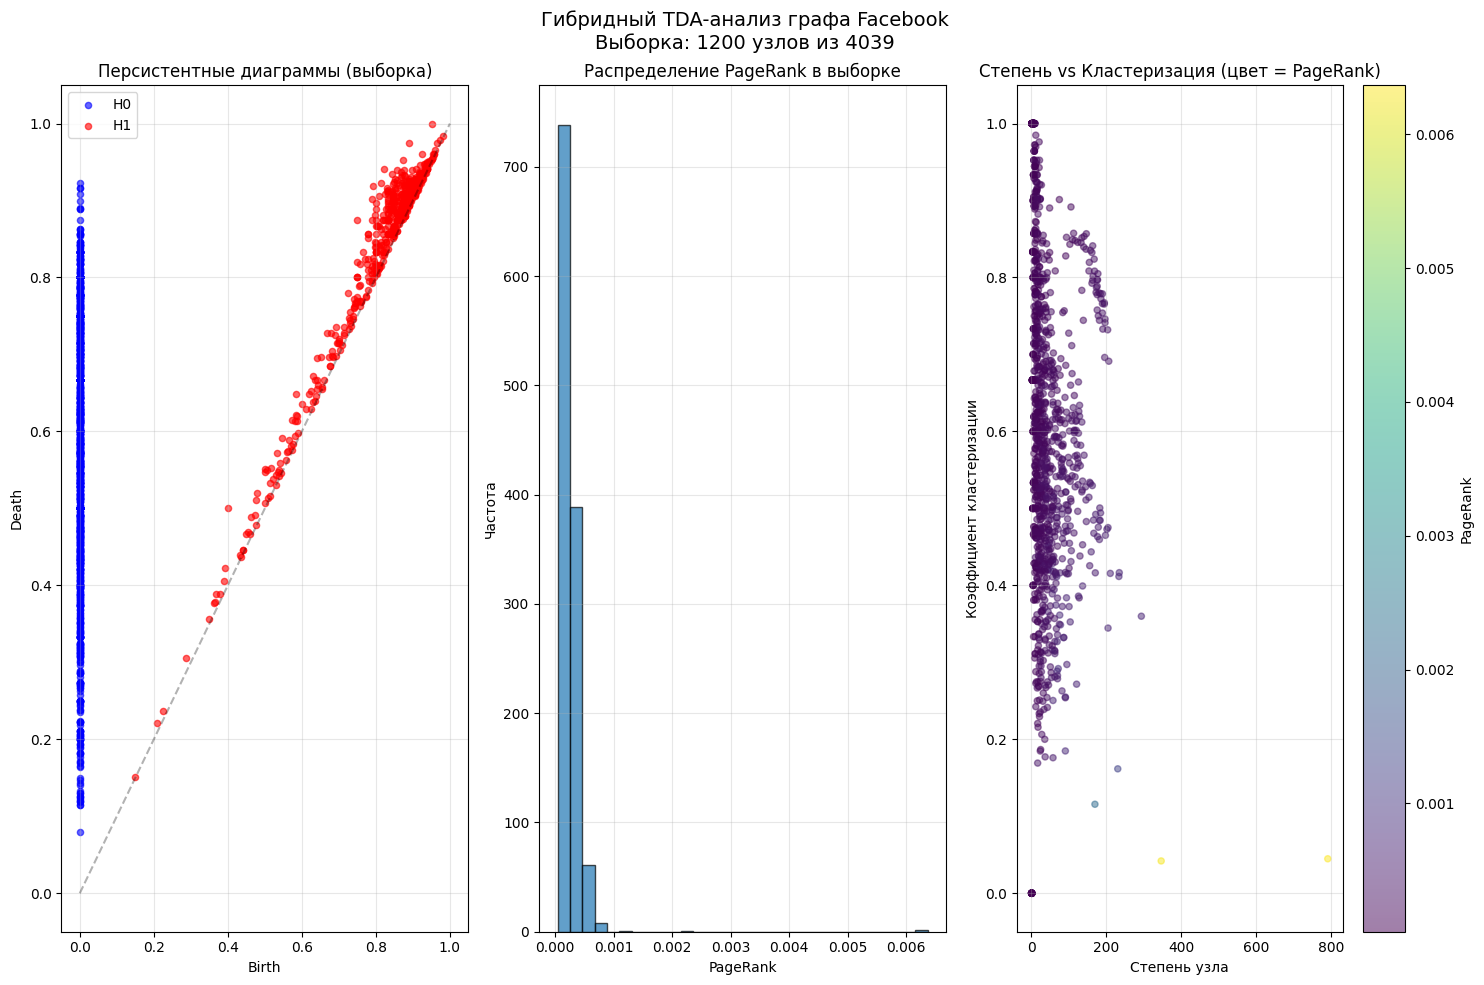


Обогащение EGO-Networks 

РЕЗУЛЬТАТЫ ДЛЯ ИСПОЛЬЗОВАНИЯ В GNN:

Пример ego-network 0:
  Размер feature matrix: (334, 13)
  Количество признаков: 13

  Первые 10 признаков:
     0. orig_feat_0
     1. orig_feat_1
     2. orig_feat_2
     3. orig_feat_3
     4. orig_feat_4
     5. global_pagerank
     6. global_betweenness
     7. global_degree_centrality
     8. global_community_id
     9. global_degree

  Значения для первого узла:
    orig_feat_0: 0.000000
    orig_feat_1: 0.000000
    orig_feat_2: 0.000000
    orig_feat_3: 0.000000
    orig_feat_4: 0.000000
    global_pagerank: 0.000410
    global_betweenness: 0.000006
    global_degree_centrality: 0.009163
    global_community_id: 0.000000
    global_degree: 37.000000

  Данные сохранены в 'enriched_ego_networks.pkl'
ВЫВОДЫ:

1. Сравнение prior'ов на разных масштабах:
   Локально (ego-nets): отрицательная ассортативность
   Глобально (весь граф): assortativity = 0.064
   → Вывод: Нейтральная ассортативность на глобальном уровне

2. 

In [45]:
results = tda_on_sample_with_global_context(G_combined, sample_size=1200)


enriched_ego_networks = enrich_ego_networks_with_global_features(ego_networks,  results['global_features'])
enriched_ego_networks, all_features = prepare_all_ego_for_gnn(enriched_ego_networks)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ДЛЯ ИСПОЛЬЗОВАНИЯ В GNN:")
print("="*70)

# Пример для первого ego-network
first_ego = list(enriched_ego_networks.keys())[0]
features_info = all_features[first_ego]

print(f"\nПример ego-network {first_ego}:")
print(f"  Размер feature matrix: {features_info['matrix'].shape}")
print(f"  Количество признаков: {len(features_info['names'])}")
print(f"\n  Первые 10 признаков:")
for i, name in enumerate(features_info['names'][:10]):
    print(f"    {i:2d}. {name}")

# Пример значений для первого узла
print(f"\n  Значения для первого узла:")
first_node_values = features_info['matrix'][0]
for i in range(min(10, len(features_info['names']))):
    print(f"    {features_info['names'][i]}: {first_node_values[i]:.6f}")

# Сохранение результатов для последующего использовани
# Сохраняем обогащённые данные
with open('enriched_ego_networks.pkl', 'wb') as f:
    pickle.dump({
        'enriched_ego_networks': enriched_ego_networks,
        'global_features': results['global_features'],
        'tda_results': results['persistence_by_dim']
    }, f)

print(f"\n  Данные сохранены в 'enriched_ego_networks.pkl'")
    
print("ВЫВОДЫ:")

# Сравнение prior'ов
print(f"\n1. Сравнение prior'ов на разных масштабах:")
print(f"   Локально (ego-nets): отрицательная ассортативность")
print(f"   Глобально (весь граф): assortativity = {results['global_features']['degree_assortativity']:.3f}")

if results['global_features']['degree_assortativity'] < -0.1:
    print(f"   → Вывод: Anti-assortative структура сохраняется на глобальном уровне")
elif results['global_features']['degree_assortativity'] > 0.1:
    print(f"   → Вывод: На глобальном уровне появляется assortativity")
else:
    print(f"   → Вывод: Нейтральная ассортативность на глобальном уровне")

# TDA результаты
if results['persistence_by_dim'].get(1):
    h1_points = results['persistence_by_dim'][1]
    lifetimes = [d - b for b, d in h1_points]
    print(f"\n2. Топологический анализ (выборка {len(results['sampled_nodes'])} узлов):")
    print(f"   Найдено H1 циклов: {len(h1_points)}")
    print(f"   Максимальное время жизни: {np.max(lifetimes):.3f}")
    stable_cycles = sum(1 for lt in lifetimes if lt > 0.1)
    print(f"   Устойчивые циклы (>0.1): {stable_cycles}")
    
    if stable_cycles > 5:
        print(f"   → Вывод: Граф имеет значимые циклические структуры")
    else:
        print(f"   → Вывод: Циклические структуры слабо выражены")

print(f"\n3. Рекомендации для проектирования GNN:")
print(f"   Обогащённые признаки ({len(all_features.get(first_ego, {}).get('names', []))} шт):")

feature_categories = {
    'Глобальные центральности': ['global_pagerank', 'global_betweenness', 'global_degree_centrality'],
    'Структурные': ['global_degree', 'local_degree', 'local_clustering'],
    'Комьюнити': ['global_community_id'],
    'Исходные': ['orig_feat_0', 'orig_feat_1', 'orig_feat_2']
}

for category, features in feature_categories.items():
    found_features = [f for f in features if any(f in name for name in all_features.get(first_ego, {}).get('names', []))]
    if found_features:
        print(f"   - {category}: {len(found_features)} признаков")
